In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [111]:
_parent_folder = "encoder_validation"
_folder_name = "sk28_et_2"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\encoder_validation'

In [112]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

_sk_df

,sys_time,time,e_t,e_fl,e_rr,e_rl,rtc,mils,sync,ax,ay,az,gx,gy,gz,mx,my,mz
0,2023-03-14 12:10:47.667655,2023-03-14 12:10:47.667788,0,0,0,0,2019-01-01 08.55.57.000000 AM,12357359,0,-0.192602,10.022484,0.002991,-0.068598,-0.022866,0.022866,245.100006,-249.300003,9.900001
1,2023-03-14 12:10:47.852166,2023-03-14 12:10:47.852342,0,0,0,0,2019-01-01 08.55.57.000000 AM,12357372,0,-0.178845,10.032652,-0.004187,-0.060976,-0.015244,0.022866,233.100006,-246.900009,7.500000
2,2023-03-14 12:10:47.852166,2023-03-14 12:10:47.852654,0,0,0,0,2019-01-01 08.55.57.000000 AM,12357384,0,-0.167480,10.049998,-0.000598,-0.053354,-0.022866,0.015244,242.700012,-246.900009,7.500000
3,2023-03-14 12:10:47.852663,2023-03-14 12:10:47.852956,0,0,0,0,2019-01-01 08.55.57.000000 AM,12357397,0,-0.177648,10.023082,-0.007776,-0.038110,-0.015244,0.022866,237.900009,-251.700012,9.900001
4,2023-03-14 12:10:47.853159,2023-03-14 12:10:47.853242,0,0,0,0,2019-01-01 08.55.57.000000 AM,12357409,0,-0.183630,10.019493,-0.001794,-0.053354,-0.030488,0.022866,230.700012,-232.500015,8.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3529,2023-03-14 12:11:32.209092,2023-03-14 12:11:32.209114,40436,0,0,0,2019-01-01 08.56.41.000000 AM,12401899,0,-0.170471,10.023082,-0.031702,-0.060976,-0.022866,0.022866,240.300003,-242.100006,4.500000
3530,2023-03-14 12:11:32.221492,2023-03-14 12:11:32.221608,40436,0,0,0,2019-01-01 08.56.41.000000 AM,12401911,0,-0.169274,10.027268,-0.044861,-0.045732,-0.030488,0.030488,235.500015,-246.900009,8.700001
3531,2023-03-14 12:11:32.233891,2023-03-14 12:11:32.234240,40436,0,0,0,2019-01-01 08.56.41.000000 AM,12401924,0,-0.187817,10.015306,-0.025720,-0.060976,-0.022866,0.022866,240.300003,-227.700012,9.300000
3532,2023-03-14 12:11:32.246788,2023-03-14 12:11:32.246850,40436,0,0,0,2019-01-01 08.56.41.000000 AM,12401937,0,-0.193798,10.038633,-0.035889,-0.053354,-0.030488,0.007622,237.900009,-237.300003,1.500000


In [113]:
# type in marker details
_xm = get_marker_name(3)
_zm = get_marker_name(1)
_om = get_marker_name(2)

In [114]:
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [115]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 3893/3893 [00:00<00:00, 124582.65it/s]


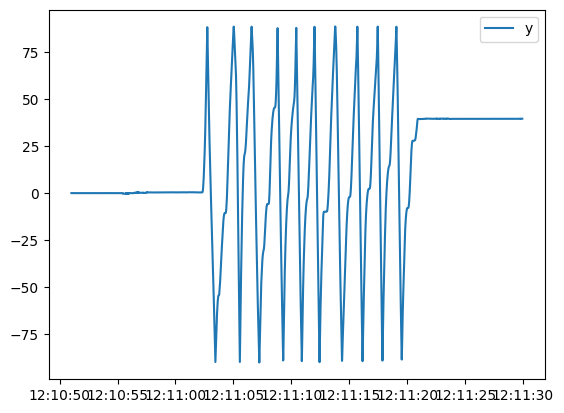

In [116]:
# plt.plot(_m_df["time"][1000:2000], _theta_x[1000:2000], label="x")

plt.plot(_m_df["time"], _theta_y, label="y")
# plt.plot(_m_df["time"][1000:2000], _theta_z[1000:2000], label="z")
# change angle to 0 to 360
plt.legend()
# max(_theta_z)

In [117]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")


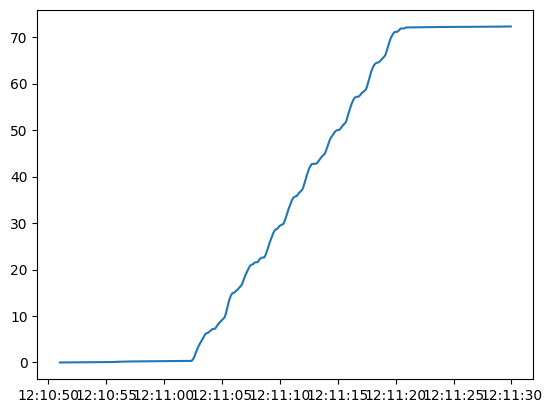

In [118]:
plt.plot(df["time"], df["theta"], label="y")

In [119]:
_ang_df = _sk_df[['time', 'e_t']].copy()

In [126]:
_ang_df["ang_y"] = _ang_df["e_t"].apply(lambda x: x*0.09)

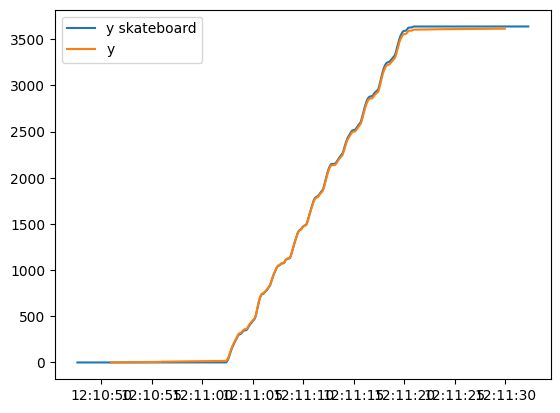

In [127]:
plt.plot(_ang_df["time"], _ang_df["ang_y"], label="y skateboard")
plt.plot(df["time"], df["theta"]*50, label="y")
plt.legend()

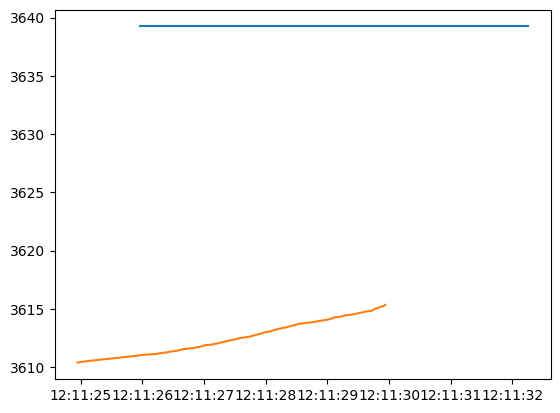

In [128]:
plt.plot(_ang_df["time"][-500:], _ang_df["ang_y"][-500:], label="y skateboard")
plt.plot(df["time"][-500:], df["theta"][-500:]*50, label="y")